# Taller ASP - Daniel Crovo - Deep Learning
**Objetivos**
- Predecir los valores futuros de una serie temporal haciendo uso de técnicas de Deep Learning.
- Implementar la optimización de hiperparámetros y cuantificar el efecto a través de métricas de desempeño.

En el ámbito de la ingenierı́a eléctrica, uno de los principales desafı́os es la planificación y gestión eficiente de la producción de energı́a eléctrica. La potencia activa es una medida de la energı́a eléctrica que se consume o se produce en un sistema eléctrico en un momento dado, y su estimación precisa es esencial para garantizar que la producción de energı́a eléctrica se ajuste a la demanda en tiempo real. Además, la potencia activa es uno de los factores clave que determinan la estabilidad y la calidad de la energı́a eléctrica suministrada a los consumidores. Por lo anterior, la predicción de la potencia activa global que se espera que se consuma o produzca en las próximas 24 horas es un problema crı́tico en la planificación y gestión de la producción de energı́a eléctrica. Una solución precisa y confiable para este problema puede ayudar a mejorar la eficiencia y la estabilidad de la red eléctrica, ası́ como a reducir los costos y las emisiones de gases de efecto invernadero asociados con la producción de energı́a eléctrica.

1. Omitiendo la primera y última fase de la metodologı́a CRISP-DM (Data Understanding, Data Preparation, Modeling y Evaluation), desarrolle un modelo de DL que, dado el consumo de energı́a de las 24 horas del dı́a anterior, tenga la capacidad de predecir el consumo de las 24 horas del dı́a siguiente. Describa la cadena de procesamiento y justifique, en detalle, cada fase que consolidó la metodologı́a empleada.
    
- **Data Understanding:** Inicialmente se explorarlos para obtener información sobre la distribución de los datos, la presencia de valores faltantes y cualquier otra característica que pueda afectar el modelado. El dataset consiste en datos de cosumo de energía (Potencia activa) y tiene tres columnas: Fecha, hora y potencia activa. El dataset tiene valores nulos.  

- **Preprocesar los datos:** Una vez que se han explorado los datos, es necesario preprocesarlos para prepararlos para el modelado, a continuación se listan los procesos realizados.
    - Se realiza el ajuste del dataframe a uno de dos columnas, en la cual se configura el index como el *time step*, esta columna es el resulatado de concatenar la fecha y hora y hacerle un cast para que sea un tipo de dato datetime. Adicionalmente a la columna index, se deja la potencia activa como la única columna.
    - Posteriormente se realiza una separación del dataset en train y test, se deja el último año (2010) como conjunto de pruebas.
    - Dado que el dataset contiene valores nulos, se remplazan estos por el valor de la media en cada conjunto de datos (entrenamiento y validación)
    - Se realiza un *re-sampling* para disminuir el tamaño del dataset, considerando que el objetivo del modelo es predecir las 24 horas del día siguiente dado un día anterior, además reduce el tiempo de entrenamiento. 

- **Crear el modelo:** En este paso, se crea un modelo de DL que pueda predecir el consumo de energía de las 24 horas del día siguiente, dados los datos de consumo de las 24 horas del día anterior. Un enfoque común para este problema es usar una red neuronal recurrente (RNN), como una red LSTM o GRU. En este caso se consideró sólamente implementar un LSTM, para lo cual se siguo la siguiente metodología:
    - Se creó una clase dataset para gestionar el conjunto de datos. en esta clase se realiza una escalización con el módulo MinMaxScaler() para escalizar los valores de potencia a un número entre 0 y 1 con el fin de reducir el tiempo de convergencia.
    - se creó un modelo base (BaseLineModel) basado en el módulo nn.LSTM que permite crear n celdas LSTM apiladas automáticamente (A diferencia de nn.LSTMCell)
    - Se creó un modelo más (CONV-LSTM-MODEL)sofisiticado utilizando dos capas convolucionales 1d para realizar extracción de características. seguido de un nn.LSTM y se agregan funciones de activación ReLU. 

- **Entrenar el modelo:** Después de crear el modelo, es necesario entrenarlo utilizando los datos de entrenamiento preprocesados.
    - Se entrenaron 2 modelos *BaseLineModel* con el fin de comparar el rendimiento utilizando una secuencia de 1440(sin *re-sampling*) o 24 (con *re-sampling*)
    - Se entrena el modelo *CONV-LSTM-MODEL*
    - Todos fueron entrenados por 5 épocas.
    - La función de pérdida escogida fue MSELOSS
    - Se escogieron 2 métricas de evaluación MSE y SMAPE (Ver referencias).

- **Evaluar el modelo:** Una vez que se ha entrenado el modelo, es necesario evaluarlo utilizando los datos de prueba preprocesados. 
    - Se evlauaron los 3 modelos, una vez entrenados se guarda el *state_dict* y se procede a realizar una evaluación con los datos de prueba. Se encontró que el modelo *CONV-LSTM-MODEL* es el que mejor rendimiento tiene. por lo cual se selecciona para realizar una optimización de hiperparametros

- **Ajustar el modelo:** Si el modelo no proporciona un rendimiento adecuado en los datos de prueba, se deben realizar ajustes en la arquitectura del modelo o en los hiperparámetros. 
    - Se plantea una optimización de hiperparámetros inicialmente por medio de gridsearch utilizando la librería optuna. El espacio de búsqueda seleccionado es el siguiente: 
    ```
    
        params = {
                    'kernel_size': [2, 4, 6],
                    'feature_size': [32, 64, 128, 256],
                    'hidden_size': [32, 64, 128, 256],
                    'n_layers': [2,4,8],
                    'lr': [0.001, 0.01],
                    'optimizer': ["Adam", 'RMSprop']}
   
    ```
    
    - Después de esta optimización por grid search, se realizará una optimización de hiperparámetros bayesiana con la librería optuna.

## Preprocesamiento de los datos

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
import os 
import numpy as np
from sklearn.metrics import mean_squared_error
import multiprocessing

data = pd.read_csv('../data/data_asp.csv')
data.head()

,Fecha,Hora,Potencia Activa Global (W)
0,16/12/2006,17:24:00,4.216
1,16/12/2006,17:25:00,5.360
2,16/12/2006,17:26:00,5.374
3,16/12/2006,17:27:00,5.388
4,16/12/2006,17:28:00,3.666


In [4]:
# Renombrar columnas y concatenar Fecha y Hora para utilizarlas como index
data.rename(columns={'Potencia Activa Global (W)':'Power'}, inplace=True) 
data['Power'] = pd.to_numeric(data['Power'], errors='coerce')
data['Datetime'] = data['Fecha'] +" "+ data['Hora']     
data['Datetime'] = pd.to_datetime(data['Datetime'], dayfirst=True)

# Se eliminan las columnas pues ya no se requieren
data.drop(['Fecha', 'Hora'], axis=1,inplace=True)
data.set_index('Datetime', inplace=True)
data.head()

,Power
Datetime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


In [5]:
train = data.loc['2006-12-16 17:24:00':'2010-01-01 00:00:00'].copy()
test = data.loc['2010-01-01 00:01:00':].copy()

In [6]:
train.shape

(1600237, 1)

In [7]:
test.shape

(475022, 1)

In [8]:
# Se verifica información básica del dataset
data.describe()

,Power
count,2.049280e+06
mean,1.091615e+00
std,1.057294e+00
min,7.600000e-02
25%,3.080000e-01
50%,6.020000e-01
75%,1.528000e+00
max,1.112200e+01


In [9]:
# Las siguientes lineas de código se utilizarn para verificar cómo están distribuidos los datos núlos

# grouped = data.groupby(by=data.index.month)
# nan = data[pd.isna(data['Power'])]
# nan = nan.fillna(1)
# nan_values = nan.groupby(by=[nan.index.month,nan.index.day,nan.index.year]).count()

data[pd.isna(data['Power'])].size

25979

Existen 25979 datos nulos, los cuales se van a reemplazar por el valor de la media.

In [10]:
#data.fillna(data['Power'].mean(), inplace=True)
train.fillna(train['Power'].mean(), inplace=True)
test.fillna(test['Power'].mean(), inplace=True)

In [11]:
# Se verifica que no queden valores nulos
data[pd.isna(data['Power'])].size

25979

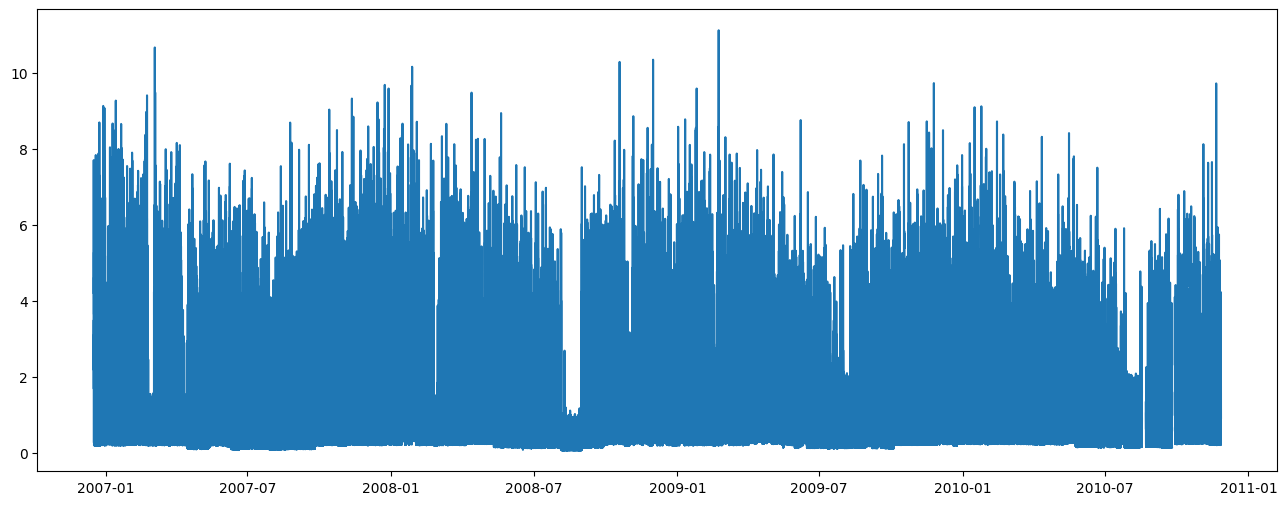

In [12]:
plt.figure(figsize=(16,6))
plt.plot(data)

Considerando que el problema consiste en predecir las siguientes 24 horas de consumo, dadas las 24 horas previas, hace sentido hacer un re-muestreo del dataset. 

In [13]:
#data_hour = data.resample('H').mean()
train_hour = train.resample('H').mean()
test_hour = test.resample('H').mean()


<Axes: xlabel='Datetime'>

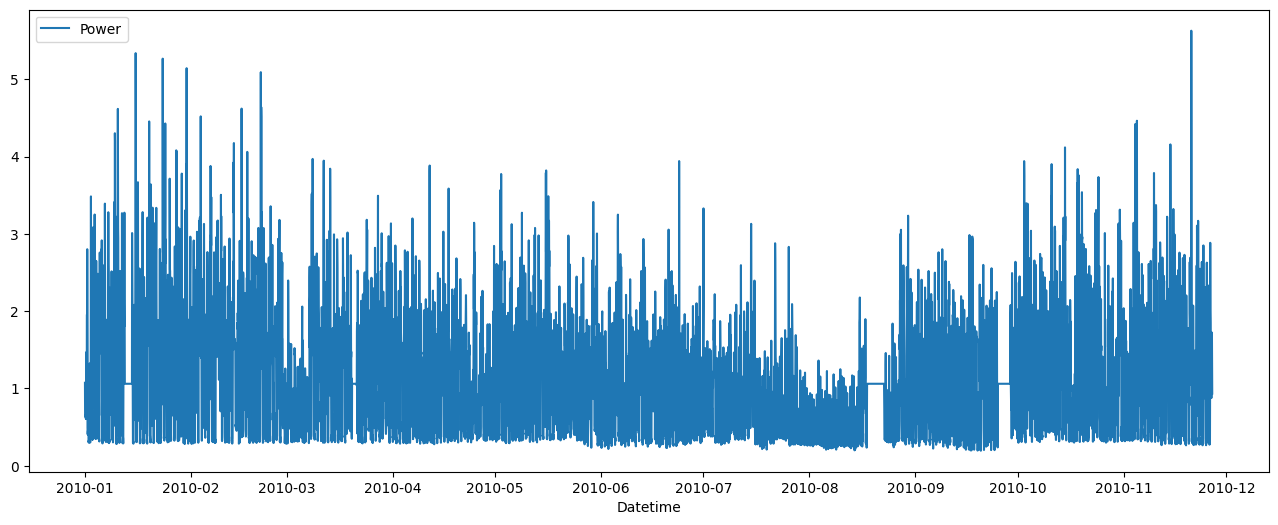

In [14]:
plt.figure(figsize=(16,6))
sns.lineplot(test_hour)

In [14]:
#input_seq = torch.tensor(scaler.transform(data.iloc[index:index+seq_length]['Power'].values.reshape(-1,1)))
#input_seq = torch.tensor(scaler.transform(input_seq))

In [15]:
# Clase para manejar el dataset
class PowerData(Dataset): 
    def __init__(self, data_df, seq_length):
        self.data = data_df
        self.seq_length = seq_length
        self.scaler = MinMaxScaler()
        self.scaler.fit(self.data[['Power']].values)

    def __getitem__(self, index):
        
        # Se retorna la secuencia del día inicial
        input_seq = torch.tensor(self.scaler.transform(self.data.iloc[index:index+self.seq_length]['Power'].values.reshape(-1,1)))
        # Se retorna la secuencia del día siguiente
        target = torch.tensor(self.scaler.transform(self.data.iloc[index+self.seq_length:index+(self.seq_length*2)]['Power'].values.reshape(-1,1)))
        return input_seq, target 
    def __len__(self): 
        return(len(self.data) - self.seq_length*2)
    # Función para retornar los datos en su escala original
    def inverse_transform(self, data): 
        return(self.scaler.inverse_transform(data))
            

In [16]:
#Modelo Base
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, seq_lenght, n_layers):
        super(BaselineModel, self).__init__()
        #Modulo LSTM de n_layer celdas
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, seq_lenght)
    def forward(self, x):
        x, (h_n, c_n) = self.lstm(x)
        # se debe aplicar la capa lineal a la última secuencia 
        x = self.linear(x[:,-1,:]).unsqueeze(-1)

        return x

In [17]:
def train_model(model, device, train_loader, optimizer, criterion, epoch):
    p_bar = tqdm(train_loader)
    model.train()

    for batch_idx, (data, target) in enumerate(p_bar):

        data, target = data.to(device), target.to(device)
        with torch.cuda.amp.autocast():
            output = model(data)
            loss = criterion(output, target)

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        p_bar.set_postfix(loss= loss.item())

In [18]:

def performance(model, device, val_loader, test_data):
    model.eval()

    with torch.no_grad():
        for x, y in val_loader:
            prev_day, next_day= x.to(device), y.to(device)
            pred = model(prev_day)

            preds = np.concatenate(pred.cpu().detach().numpy())
            targets = np.concatenate(next_day.cpu().detach().numpy())

    
 
    smape = (100/len(targets))*np.sum((np.abs(preds-targets))/((np.abs(targets+preds))/2))
    print('Simetric mean absolute percentage error: ', smape)
    preds = test_data.inverse_transform(preds.reshape(-1,1))
    targets = test_data.inverse_transform(targets.reshape(-1,1))
    mse = mean_squared_error(preds, targets)
    print('Mean Squared Error: ', mse)
    return preds, targets, mse

In [18]:
# Hyperparámetros
batch_size = 32
epochs = 5
lr  = 0.001
input_size =1
seq_lenght = 24
hidden_size = 64
n_layers = 2
NUM_WORKERS = multiprocessing.cpu_count()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')

train_data = PowerData(train_hour, seq_lenght)
test_data = PowerData(test_hour, seq_lenght)

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=NUM_WORKERS)

model = BaselineModel(input_size, hidden_size, seq_lenght, n_layers).to(device)
model.double()
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(1, epochs+1):
    train_model(model, device, train_loader, optimizer, criterion, epoch)
    print('____________________________\nValidation metrics in training epoch ', epoch,':')
    performance(model, device, train_loader, train_data)

print('____________________________\nValidation metrics in test set:')
performance(model, device, test_loader, test_data)

torch.save(model.state_dict(), '../models/model_24hours')


Training on cuda


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  1 :
Simetric mean absolute percentage error:  70.83012892145157
Mean Squared Error:  1.1963075646654417


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  2 :
Simetric mean absolute percentage error:  69.90691420961589
Mean Squared Error:  1.1640978693483672


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  3 :
Simetric mean absolute percentage error:  58.628519576475924
Mean Squared Error:  0.9331951916820462


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  4 :
Simetric mean absolute percentage error:  57.76546784488653
Mean Squared Error:  0.8989365959008228


  0%|          | 0/832 [00:00<?, ?it/s]

____________________________
Validation metrics in training epoch  5 :
Simetric mean absolute percentage error:  55.63718530041381
Mean Squared Error:  0.8545962717131937
____________________________
Validation metrics in test set:
Simetric mean absolute percentage error:  69.14646096403965
Mean Squared Error:  0.27568597160793057


In [19]:
batch_size = 32
epochs = 2
lr  = 0.001
input_size =1
seq_lenght = 1440
hidden_size = 64
n_layers = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')

train_data_h = PowerData(train, seq_lenght)
test_data_h = PowerData(test, seq_lenght)

train_loader_h = DataLoader(train_data_h, batch_size=batch_size, num_workers=NUM_WORKERS)
test_loader_h = DataLoader(test_data_h, batch_size=batch_size, num_workers=NUM_WORKERS)

model_hour = BaselineModel(input_size, hidden_size, seq_lenght, n_layers).to(device)
model_hour.double()
optimizer_h = optim.Adam(model_hour.parameters(), lr=lr)
criterion_h = nn.MSELoss()

for epoch in range(1, epochs+1):
    train_model(model_hour, device, train_loader_h, optimizer_h, criterion_h, epoch)
    print('____________________________\nValidation metrics in training epoch ', epoch,':')
    performance(model_hour, device, train_loader_h, train_data_h)


print('____________________________\nValidation metrics in test set:')
performance(model_hour, device, test_loader_h, test_data)

torch.save(model_hour.state_dict(), '../models/model_by_hours')



Training on cuda


  0%|          | 0/49918 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Evaluación de los dos modelos base

In [53]:
model_baseline24 = BaselineModel(24, hidden_size, 24, 1).to(device)
model_baseline24.load_state_dict(torch.load('../models/model_24hours'))
model_baseline24.eval()
model_baseline24.double()
model_baseline_h = BaselineModel(1440, hidden_size, 1440, 1).to(device)
model_baseline_h.load_state_dict(torch.load('../models/model_by_hours'))
model_baseline_h.eval()
model_baseline_h.double()


#train_data_24 = PowerData(train_hour, input_size)
test_data_24 = PowerData(test_hour, 24)
test_data_h = PowerData(test, 1440)

#train_loader_24 = DataLoader(train_data_24, batch_size=batch_size)
test_loader_24 = DataLoader(test_data_24, batch_size=batch_size)
test_loader_h = DataLoader(test_data_h, batch_size=batch_size)

y_pred_24, y_true_24  = performance(model_baseline24, device, test_loader_24,test_data_24)
y_pred_h, y_true_h = performance(model_baseline_h, device, test_loader_h,test_data_h)


print(f'el RMSE para el modelo que trabaja con una secuencia de 24 y fue remuestreado es: {mean_squared_error(y_true_24, y_pred_24)}')
print(f'el RMSE para el modelo que trabaja con una secuencia de 1440: {mean_squared_error(y_true_h, y_pred_h)}')

 Simetric mean absolite percentage error:  49.952956468720465
 Simetric mean absolite percentage error:  92.05622365027949
el RMSE para el modelo que trabaja con una secuencia de 24 y fue remuestreado es: 0.22176545441372247
el RMSE para el modelo que trabaja con una secuencia de 1440: 0.8926358807504763


## Modelo con extracción de características por Convolución

In [19]:
class CONV_LSTM_Model(nn.Module):
    def __init__(self, input_size=1, kernel_size=3, feature_size=32, hidden_size=64, seq_lenght=24, n_layers=2, padding=1):
        super(CONV_LSTM_Model, self).__init__()
        self.conv1d_1 = nn.Conv1d(in_channels=input_size, out_channels=feature_size, kernel_size=kernel_size, padding=padding)
        self.conv1d_2 = nn.Conv1d(in_channels=feature_size, out_channels=feature_size, kernel_size=kernel_size, padding=padding)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size*feature_size, hidden_size, n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, seq_lenght)
    def forward(self, x):
        x = x.permute(0,2,1)

        x = self.conv1d_1(x)
        x = self.relu(x)
        x = self.conv1d_2(x)
        x = self.relu(x)
        x = x.permute(0
                      ,2,1)
        x, h = self.lstm(x)
        x = self.linear(x[:,-1,:]).unsqueeze(-1)
        x = self.relu(x)

        return x

In [21]:
# Hyperparámetros
batch_size = 32
epochs = 5
lr  = 0.001
input_size =1
seq_lenght = 24
kernel_size = 3
feature_size = 64
padding = 1
hidden_size = 64
n_layers = 2
NUM_WORKERS = multiprocessing.cpu_count()


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')

train_data = PowerData(train_hour, seq_lenght)
test_data = PowerData(test_hour, seq_lenght)

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

conv_lstm_model = CONV_LSTM_Model(input_size, kernel_size, feature_size, hidden_size, seq_lenght, n_layers, padding).to(device)
conv_lstm_model.double()
optimizer = optim.Adam(conv_lstm_model.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(1, epochs+1):
    train_model(conv_lstm_model, device, train_loader, optimizer, criterion, epoch)
    performance(conv_lstm_model, device, train_loader, train_data)

torch.save(model.state_dict(), '../models/model_conv_lstm')

preds, truth = performance(conv_lstm_model, device, test_loader, test_data)


Training on cuda


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  80.33913907208179
Mean Squared Error:  1.2905434157222497


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  60.978992506619846
Mean Squared Error:  0.9270298114555443


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  53.087492973774154
Mean Squared Error:  0.7671527968380193


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  52.95363446938451
Mean Squared Error:  0.7606238378101824


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  53.27692957110997
Mean Squared Error:  0.7623179823245684
Simetric mean absolute percentage error:  66.51576631252136
Mean Squared Error:  0.25462780683900493


## Optimización de hiperparámetros
Considerando que el modelo con las capas convolucionales para extracción de características presenta un mejor desempeño en el entrenamiento así como evaluado en el conjunto de pruebas, se procede a realizar la optimización de hiperparámetros para este. 

In [20]:
import optuna
from sklearn.model_selection import cross_val_score


batch_size = 32
epochs = 3
input_size =1
seq_lenght = 24
padding = 1
NUM_WORKERS = multiprocessing.cpu_count()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')
train_data = PowerData(train_hour, seq_lenght)
test_data = PowerData(test_hour, seq_lenght)

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=NUM_WORKERS)


def objective(trial):

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    kernel_size = trial.suggest_int('kernel_size', 2,8)
    feature_size = trial.suggest_int('feature_size', 32, 256)
    hidden_size = trial.suggest_int('hidden_size', 32, 256)
    n_layers = trial.suggest_int('n_layers', 1, 64)

    model_HO = CONV_LSTM_Model(input_size, kernel_size, feature_size, hidden_size, seq_lenght, n_layers, padding).to(device)
    optimizer = getattr(optim, optimizer_name)(model_HO.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model_HO.double()
    for epoch in range(epochs):
        train_model(model_HO, device, train_loader, optimizer, criterion, epoch)
        preds, targets, mse_epoch = performance(model_HO, device, test_loader, test_data)
        trial.report(mse_epoch, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    preds_final, targets_final, mse = performance(model_HO, device, test_loader, test_data)
    return mse

params = {
    'kernel_size': [2, 4, 6],
    'feature_size': [32, 64, 128, 256],
    'hidden_size': [32, 64, 128, 256],
    'n_layers': [2,4,8],
    'lr': [0.001, 0.01],
    'optimizer': ["Adam", 'RMSprop']

}
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.GridSampler(params))
study.optimize(objective, n_trials=100, timeout=900)


# Get the best hyperparameters and their corresponding score
best_params = study.best_params
best_score = study.best_value

# Print the best hyperparameters and score
print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

[I 2023-05-15 16:09:53,064] A new study created in memory with name: no-name-8bd944d9-646c-4c0f-990c-bf10f727e912


Training on cuda


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  88.06649516258739
Mean Squared Error:  0.6494745906595718


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  83.37467746901933
Mean Squared Error:  0.6118592028472312


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  83.38071036882812
Mean Squared Error:  0.6123586014333229


[I 2023-05-15 16:10:43,118] Trial 0 finished with value: 0.6123586014333229 and parameters: {'optimizer': 'RMSprop', 'lr': 0.01, 'kernel_size': 2, 'feature_size': 32, 'hidden_size': 64, 'n_layers': 4}. Best is trial 0 with value: 0.6123586014333229.


Simetric mean absolute percentage error:  83.38071036882812
Mean Squared Error:  0.6123586014333229


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  74.8439888715916
Mean Squared Error:  0.4897407332157482


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  75.24874923442924
Mean Squared Error:  0.42183803725458635


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  75.71361861786752
Mean Squared Error:  0.4030840184904902


[I 2023-05-15 16:11:40,556] Trial 1 finished with value: 0.4030840184904902 and parameters: {'optimizer': 'RMSprop', 'lr': 0.001, 'kernel_size': 2, 'feature_size': 32, 'hidden_size': 128, 'n_layers': 2}. Best is trial 1 with value: 0.4030840184904902.


Simetric mean absolute percentage error:  75.71361861786752
Mean Squared Error:  0.4030840184904902


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  89.36288786840144
Mean Squared Error:  0.5078573451187048


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  73.5971487292936
Mean Squared Error:  0.31583303713836686


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  71.9112369110994
Mean Squared Error:  0.3000680470976883


[I 2023-05-15 16:12:27,598] Trial 2 finished with value: 0.3000680470976883 and parameters: {'optimizer': 'Adam', 'lr': 0.001, 'kernel_size': 4, 'feature_size': 128, 'hidden_size': 64, 'n_layers': 2}. Best is trial 2 with value: 0.3000680470976883.


Simetric mean absolute percentage error:  71.9112369110994
Mean Squared Error:  0.3000680470976883


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  121.18618512518854
Mean Squared Error:  0.7921107755433445


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  200.0
Mean Squared Error:  1.248509251300926


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  200.0
Mean Squared Error:  1.248509251300926


[I 2023-05-15 16:15:04,678] Trial 3 finished with value: 1.248509251300926 and parameters: {'optimizer': 'RMSprop', 'lr': 0.001, 'kernel_size': 6, 'feature_size': 128, 'hidden_size': 256, 'n_layers': 4}. Best is trial 2 with value: 0.3000680470976883.


Simetric mean absolute percentage error:  200.0
Mean Squared Error:  1.248509251300926


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  104.73453616204198
Mean Squared Error:  0.6253098751490471


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  96.45200264550262
Mean Squared Error:  0.499544921163057


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  82.54927773684702
Mean Squared Error:  0.38557836939998097


[I 2023-05-15 16:15:50,163] Trial 4 finished with value: 0.38557836939998097 and parameters: {'optimizer': 'Adam', 'lr': 0.001, 'kernel_size': 2, 'feature_size': 256, 'hidden_size': 32, 'n_layers': 4}. Best is trial 2 with value: 0.3000680470976883.


Simetric mean absolute percentage error:  82.54927773684702
Mean Squared Error:  0.38557836939998097


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-15 16:16:18,292] Trial 5 pruned. 


Simetric mean absolute percentage error:  135.73715192043758
Mean Squared Error:  0.8810525810371153


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  71.76532859349865
Mean Squared Error:  0.4296834058807766


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  69.40481916458688
Mean Squared Error:  0.3569638213368656


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  69.5335686799552
Mean Squared Error:  0.3442552451405631


[I 2023-05-15 16:16:52,841] Trial 6 finished with value: 0.3442552451405631 and parameters: {'optimizer': 'RMSprop', 'lr': 0.001, 'kernel_size': 6, 'feature_size': 32, 'hidden_size': 64, 'n_layers': 2}. Best is trial 2 with value: 0.3000680470976883.


Simetric mean absolute percentage error:  69.5335686799552
Mean Squared Error:  0.3442552451405631


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  96.57581505591956
Mean Squared Error:  0.5284674870454427


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  78.74104234450769
Mean Squared Error:  0.3669228663026928


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  75.16238156005593
Mean Squared Error:  0.32022978242794886


[I 2023-05-15 16:17:45,417] Trial 7 finished with value: 0.32022978242794886 and parameters: {'optimizer': 'Adam', 'lr': 0.001, 'kernel_size': 4, 'feature_size': 64, 'hidden_size': 128, 'n_layers': 2}. Best is trial 2 with value: 0.3000680470976883.


Simetric mean absolute percentage error:  75.16238156005593
Mean Squared Error:  0.32022978242794886


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  86.76350058040981
Mean Squared Error:  0.46621903290055583


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  72.63841259293972
Mean Squared Error:  0.3183622429515835


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  69.83289801427867
Mean Squared Error:  0.27811501783204584


[I 2023-05-15 16:20:21,408] Trial 8 finished with value: 0.27811501783204584 and parameters: {'optimizer': 'Adam', 'lr': 0.001, 'kernel_size': 6, 'feature_size': 128, 'hidden_size': 256, 'n_layers': 4}. Best is trial 8 with value: 0.27811501783204584.


Simetric mean absolute percentage error:  69.83289801427867
Mean Squared Error:  0.27811501783204584


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-15 16:22:17,219] Trial 9 pruned. 


Simetric mean absolute percentage error:  80.95207335007424
Mean Squared Error:  0.5498746414150242


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  76.2273197147097
Mean Squared Error:  0.47430502918953704


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  68.97121776629231
Mean Squared Error:  0.3503743824875709


  0%|          | 0/832 [00:00<?, ?it/s]

Simetric mean absolute percentage error:  68.05131032002974
Mean Squared Error:  0.30684195179850815


[I 2023-05-15 16:22:49,182] Trial 10 finished with value: 0.30684195179850815 and parameters: {'optimizer': 'RMSprop', 'lr': 0.001, 'kernel_size': 4, 'feature_size': 128, 'hidden_size': 32, 'n_layers': 2}. Best is trial 8 with value: 0.27811501783204584.


Simetric mean absolute percentage error:  68.05131032002974
Mean Squared Error:  0.30684195179850815


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-15 16:23:35,183] Trial 11 pruned. 


Simetric mean absolute percentage error:  200.0
Mean Squared Error:  1.248509251300926


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-15 16:23:43,740] Trial 12 pruned. 


Simetric mean absolute percentage error:  96.95838244628231
Mean Squared Error:  0.5399680696686333


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-15 16:24:03,135] Trial 13 pruned. 


Simetric mean absolute percentage error:  200.0
Mean Squared Error:  1.248509251300926


  0%|          | 0/832 [00:00<?, ?it/s]

[I 2023-05-15 16:24:57,321] Trial 14 pruned. 


Simetric mean absolute percentage error:  200.0
Mean Squared Error:  1.248509251300926
Best Hyperparameters: {'optimizer': 'Adam', 'lr': 0.001, 'kernel_size': 6, 'feature_size': 128, 'hidden_size': 256, 'n_layers': 4}
Best Score: 0.27811501783204584


El segundo mejor
```
{'optimizer': 'Adam',
 'lr': 0.001, 
 'kernel_size': 4, 
 'feature_size': 128, 
 'hidden_size': 64, 
 'n_layers': 2}
 ```

El mejor

``` 
{'optimizer': 'Adam',
 'lr': 0.001,
 'kernel_size': 6,
 'feature_size': 128,
 'hidden_size': 256,
 'n_layers': 4}
 ```

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score


batch_size = 32
epochs = 3
input_size =1
seq_lenght = 24
padding = 1
feature_size = 128
NUM_WORKERS = multiprocessing.cpu_count()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')
train_data = PowerData(train_hour, seq_lenght)
test_data = PowerData(test_hour, seq_lenght)

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=NUM_WORKERS)


def objective(trial):

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    kernel_size = trial.suggest_int('kernel_size', 6,8)
    #feature_size = trial.suggest_int('feature_size', 32, 256)
    hidden_size = trial.suggest_int('hidden_size', 64, 256)
    n_layers = trial.suggest_int('n_layers', 2, 6)

    model_HO = CONV_LSTM_Model(input_size, kernel_size, feature_size, hidden_size, seq_lenght, n_layers, padding).to(device)
    optimizer = getattr(optim, optimizer_name)(model_HO.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model_HO.double()
    for epoch in range(epochs):
        train_model(model_HO, device, train_loader, optimizer, criterion, epoch)
        preds, targets, mse_epoch = performance(model_HO, device, test_loader, test_data)
        trial.report(mse_epoch, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    preds_final, targets_final, mse = performance(model_HO, device, test_loader, test_data)
    return mse

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100, timeout=1200)


# Get the best hyperparameters and their corresponding score
best_params = study.best_params
best_score = study.best_value

# Print the best hyperparameters and score
print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

## Referencias: 
1. https://towardsdatascience.com/hyperparameter-tuning-of-neural-networks-with-optuna-and-pytorch-22e179efc837
2. https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py 
3. https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstms
4. [LONG SHORT-TERM MEMORY BASED RECURRENT NEURAL NETWORK ARCHITECTURES FOR LARGE VOCABULARY SPEECH RECOGNITION](https://arxiv.org/pdf/1402.1128.pdf)
5. [Multi-Step Short-Term Power Consumption Forecasting with a Hybrid Deep Learning Strategy](https://www.mdpi.com/1996-1073/11/11/3089)
6. [Simetric Mean Absolute Percentage Error](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error#:~:text=Symmetric%20mean%20absolute%20percentage%20error%20(SMAPE%20or%20sMAPE)%20is%20an,t%20is%20the%20forecast%20value.)